In [1]:
from hydra import initialize, compose

with initialize("../configs", version_base="1.2.0"):
    cfg = compose("config.yaml", overrides=["dataset=imagenet", "compute.distributed=False"])

import dotenv
dotenv.load_dotenv("../.env")


import os
os.environ["IMAGE_NET_PATH"]

''

In [3]:
cfg.paths.checkpoints

'/home/mklasby/projects/def-yani/mklasby/condensed-sparsity/artifacts/checkpoints'

In [6]:
from rigl_torch.utils.checkpoint import Checkpoint


ckp = Checkpoint.load_last_checkpoint(run_id="vchnjrf5", rank=0, parent_dir=cfg.paths.checkpoints,)

In [11]:
ckp.pruner.keys()



dict_keys(['dense_allocation', 'S', 'N', 'delta_T', 'alpha', 'T_end', 'ignore_linear_layers', 'static_topo', 'sparsity_distribution', 'grad_accumulation_n', 'erk_power_scale', 'static_ablation', 'dynamic_ablation', 'min_salient_weights_per_neuron', 'step', 'rigl_steps', 'backward_masks', '_linear_layers_mask', 'itop_rs', 'explored_params', 'active_neurons', 'static_ablated_filters'])

In [16]:
from rigl_torch.models import ModelFactory
from torch.nn.parallel import DistributedDataParallel
import torch

# torch.distributed.init_process_group(
#             backend=cfg.compute.dist_backend,
#             world_size=1,
#             rank=0,
# )

model = ModelFactory.load_model(model="resnet50", dataset="imagenet")
model.to(device=f"cuda:0")
model.load_state_dict({".".join(k.split(".")[1:]): v for k,v in ckp.model.items()})

# def test(cfg, model, device, test_loader, epoch, step, rank, logger):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             logits = model(data)
#             test_loss += F.cross_entropy(
#                 logits,
#                 target,
#                 label_smoothing=cfg.training.label_smoothing,
#                 reduction="mean",
#             )
#             pred = logits.argmax(
#                 dim=1, keepdim=True
#             )  # get the index of the max log-probability
#             correct += pred.eq(target.view_as(pred)).sum()
#     if cfg.compute.distributed:
#         dist.all_reduce(test_loss, dist.ReduceOp.AVG, async_op=False)
#         dist.all_reduce(correct, dist.ReduceOp.SUM, async_op=False)
#     if rank == 0:
#         wandb_log(
#             epoch,
#             test_loss,
#             correct / len(test_loader.dataset),
#             data,
#             logits,
#             target,
#             pred,
#             step,
#         )
#         logger.info(
#             "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
#                 test_loss,
#                 correct,
#                 len(test_loader.dataset),
#                 100.0 * correct / len(test_loader.dataset),
#             )
#         )
#     return test_loss, correct / len(test_loader.dataset)

INFO:/home/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model resnet50/imagenet using <function get_imagenet_resnet50 at 0x7f3438534700> with args: () and kwargs: {}


<All keys matched successfully>

In [17]:
from rigl_torch.datasets import get_dataloaders
_, test_loader = get_dataloaders(cfg)

In [18]:
model.eval()
device = torch.device(f"cuda:0")
import torch.nn.functional as F
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        logits = model(data)
        test_loss += F.cross_entropy(
            logits,
            target,
            label_smoothing=cfg.training.label_smoothing,
            reduction="mean",
        )
        pred = logits.argmax(
            dim=1, keepdim=True
        )  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum()

In [41]:
target[0]

tensor(980, device='cuda:0')

In [40]:
logits[0].argmax()

tensor(980, device='cuda:0')

In [28]:
target.shape

torch.Size([1000])

In [35]:
pred.eq(target.view_as(pred)).sum()

tensor(801, device='cuda:0')

In [34]:
(pred[:,0] == target).sum()

tensor(801, device='cuda:0')

In [22]:
correct/len(test_loader.dataset)

tensor(0.6749, device='cuda:0')

In [9]:
import wandb
print(wandb.run)

None


In [5]:
import torch

torch.cuda.device_count()

4

In [2]:
cfg.dataset.name

'imagenet'

In [3]:
from rigl_torch.datasets import get_dataloaders

In [ ]:
# import pathlib
# def _load_meta_file():
#     meta_file = (
#         pathlib.Path("../data") / "synset_words.txt"
#     )
#     with meta_file.open() as handle:
#         meta_data = handle.readlines()
#     return meta_data

# meta_data = _load_meta_file()

In [ ]:
# meta_dict = {line.split(" ")[0]: " ".join(line.split(" ")[1:])[:-1] for line in meta_data}

In [ ]:
# import yaml
# with open("imagetnet_labels.yaml", "w") as handle:
#     yaml.dump(meta_dict, handle)

In [5]:
train_loader, test_loader = get_dataloaders(cfg)

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F

for imgs, labels in train_loader:
    break
# print(mini_batch.shape)

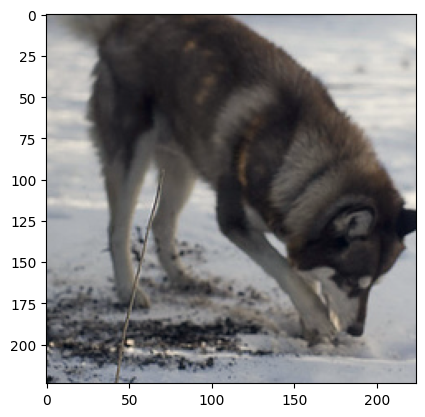

In [7]:
import matplotlib.pyplot as plt
def norm_image(img):
    min = torch.abs(img.min())
    max = (img + min).max()
    return (img+min)/max

norm = norm_image(imgs[0])
plt.imshow(norm.permute(1,2,0))


In [ ]:
        self.wnids = self.classes
        self.wnid_to_idx = self.class_to_idx
        self.classes = [wnid_to_classes[wnid] for wnid in self.wnids]
        self.class_to_idx = {
            clss: idx for idx, clss in enumerate(self.classes) for clss in clss
        }

In [11]:
labels[0]

tensor(250)

In [13]:
train_loader.dataset.idx_to_class[labels[0].item()]

'Siberian husky'

In [10]:
labels[0]

tensor(250)

In [15]:
test_loader.dataset

Dataset CCImageNetFolder
    Number of datapoints: 50000
    Root location: /datashare/ImageNet/ILSVRC2012/validation
    StandardTransform
Transform: Compose(
               ToTensor()
               PerImageStandarization()
               Pad(padding=4, fill=0, padding_mode=reflect)
               CenterCrop(size=[224, 224])
               RandomHorizontalFlip(p=0.5)
           )

In [18]:
s="asdf"
type(s)==str

True

In [14]:
imgs.shape

torch.Size([128, 3, 224, 224])

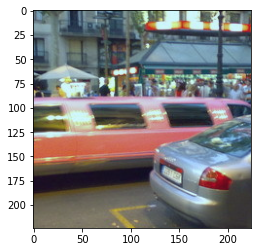

In [25]:
norm = norm_image(imgs[0])
plt.imshow(norm.permute(1,2,0))

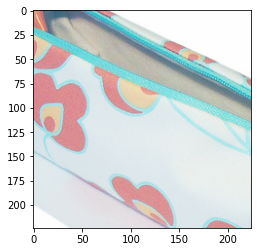

In [26]:
norm = norm_image(imgs[1])
plt.imshow(norm.permute(1,2,0))

In [12]:
imgs[0].max()

tensor(2.8865)

In [11]:
norm.max()

tensor(1.7155)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


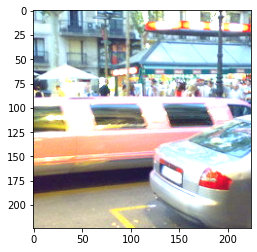

In [9]:
import matplotlib.pyplot as plt
plt.imshow(norm.permute(1,2,0))